Some fun (is it fun?) looks at Black Scholes. Referencing this link [here](https://www.codearmo.com/python-tutorial/options-trading-black-scholes-model).

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [2]:
class BsOption:
    def __init__(self, S, K, T, r, sigma, q=0):
        self.S = S
        self.K = K
        self.T = T
        self.r = r 
        self.sigma = sigma
        self.q = q
        
    
    @staticmethod
    def N(x):
        return norm.cdf(x)
    
    @property
    def params(self):
        return {'S': self.S, 
                'K': self.K, 
                'T': self.T, 
                'r':self.r,
                'q':self.q,
                'sigma':self.sigma}
    
    def d1(self):
        return (np.log(self.S/self.K) + (self.r -self.q + self.sigma**2/2)*self.T) \
                                / (self.sigma*np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma*np.sqrt(self.T)
    
    def _call_value(self):
        return self.S*np.exp(-self.q*self.T)*self.N(self.d1()) - \
                    self.K*np.exp(-self.r*self.T) * self.N(self.d2())
                    
    def _put_value(self):
        return self.K*np.exp(-self.r*self.T) * self.N(-self.d2()) -\
                self.S*np.exp(-self.q*self.T)*self.N(-self.d1())
    
    def price(self, type_ = 'C'):
        if type_ == 'C':
            return self._call_value()
        if type_ == 'P':
            return self._put_value() 
        if type_ == 'B':
            return  {'call': self._call_value(), 'put': self._put_value()}
        else:
            raise ValueError('Unrecognized type')
    
def N(x):
    return norm.cdf(x)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

In [3]:
K = 100
r = 0.1
T = 1
sigma = 0.3
S = 100
print(BsOption(S, K, T, r, sigma).price('B'))

{'call': np.float64(16.73413358238666), 'put': np.float64(7.217875385982609)}


| Var | Definition|
|---|---|
| S | Current Price |
| K | Strike Price |
| r | Risk-Free Rate |
| T | Time to expiry, years |
| sigma | annualized volatility |

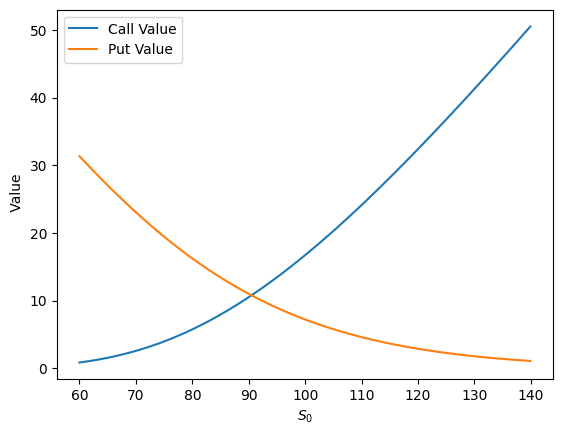

In [4]:
K = 100
r = 0.1
T = 1
sigma = 0.3

S = np.arange(60,140,0.1)

calls = [BsOption(s, K, T, r, sigma).price('C') for s in S]
puts = [BsOption(s, K, T, r, sigma).price('P') for s in S]
plt.plot(S, calls, label='Call Value')
plt.plot(S, puts, label='Put Value')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.legend()

Time to generate some training data to throw a variational-autoencoder at.

In [5]:
# make parameter space
S = np.arange(50, 150, 5).tolist()
K = np.arange(50, 150, 5).tolist()
r = np.arange(0.01, 0.1, 0.01).tolist()
T = np.arange(0.0, 2, 0.1).tolist()
sigma = np.arange(0.05, 0.2, 0.05).tolist()
len(S) * len(K) * len(r) * len(T) * len(sigma)

288000

In [6]:
params = [S, K, r, T, sigma]
space = np.array(list(itertools.product(*params)))

In [7]:
call_prices = np.array([BS_CALL(*param) for param in space])

In [8]:
call_df = pd.DataFrame(np.hstack((space, call_prices.reshape(-1,1))), columns=["S", "K", "r", "T", "sigma", "CallPrice"])

In [9]:
call_df.to_csv("calldf.csv", index=False)